[lap-mathurin-01:932515] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.lap-mathurin-01.1000/jf.0/1236205568/shared_mem_cuda_pool.lap-mathurin-01 could be created.
[lap-mathurin-01:932515] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


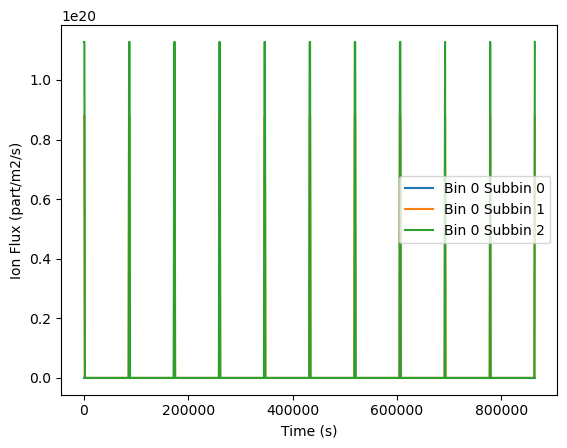

In [1]:
from iter_all_bin_scenario import plasma_data_handling, my_scenario, FW_bins

import numpy as np
import matplotlib.pyplot as plt

first_pulse = my_scenario.pulses[0]
t = np.linspace(0, first_pulse.total_duration * first_pulse.nb_pulses, 1000)
FW_bin = FW_bins.bins[0]
for i, sub_bin in enumerate(FW_bin.sub_bins):
    ion_flux = []
    for t_val in t:
        ion_flux.append(
            plasma_data_handling.get_particle_flux(first_pulse, bin=sub_bin, t_rel=t_val, ion=True)
        )
    plt.plot(t, ion_flux, label=f"Bin {FW_bin.index} Subbin {i}")
plt.xlabel("Time (s)")
plt.ylabel("Ion Flux (part/m2/s)")
plt.legend()
plt.show()


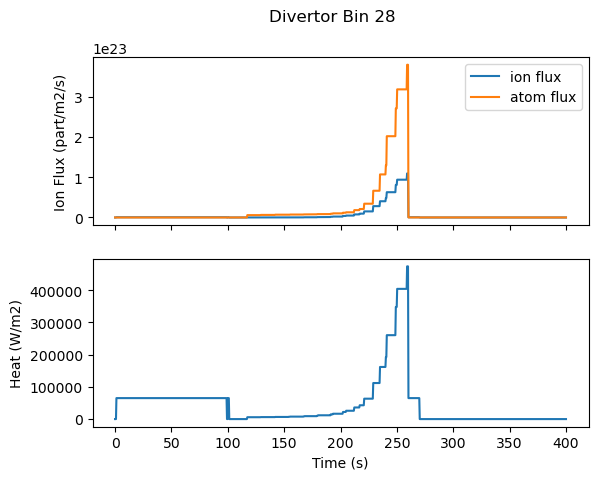

In [6]:
from iter_all_bin_scenario import plasma_data_handling, Div_bins

from hisp.scenario import Pulse

import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 400, 1000)
div_bin = Div_bins.bins[10]

assert div_bin.outer_bin

RISP_pulse = Pulse(
    pulse_type="RISP",
    nb_pulses=1,
    ramp_up=0,
    ramp_down=0,
    steady_state=400,
    waiting=0,
    tritium_fraction=0,
)
t = np.linspace(0, RISP_pulse.total_duration, 1000)

ion_flux = []
atom_flux = []
heat_flux = []
for t_val in t:
    ion_flux.append(
        plasma_data_handling.get_particle_flux(RISP_pulse, bin=div_bin, t_rel=t_val, ion=True)
    )
    atom_flux.append(
        plasma_data_handling.get_particle_flux(RISP_pulse, bin=div_bin, t_rel=t_val, ion=False)
    )
    heat_flux.append(
        plasma_data_handling.get_heat(RISP_pulse, bin=div_bin, t_rel=t_val)
    )

fig, axs = plt.subplots(2, sharex=True)
plt.suptitle(f"Divertor Bin {div_bin.index}")
plt.sca(axs[0])
plt.plot(t, ion_flux, label="ion flux")
plt.plot(t, atom_flux, label=f"atom flux")
plt.legend()
plt.ylabel("Ion Flux (part/m2/s)")
plt.sca(axs[1])
plt.plot(t, heat_flux, label=f"Heat flux")
plt.ylabel("Heat (W/m2)")
plt.xlabel("Time (s)")
plt.show()


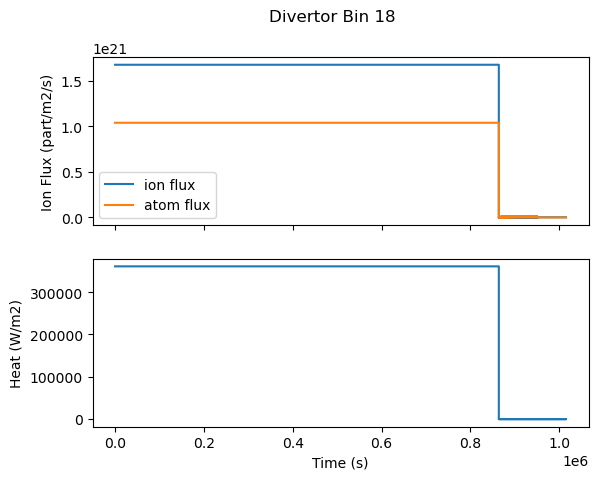

In [ ]:
from iter_all_bin_scenario import plasma_data_handling, Div_bins, my_scenario

import numpy as np
import matplotlib.pyplot as plt


div_bin = Div_bins.bins[0]

ion_flux = []
atom_flux = []
heat_flux = []
t = []
t_current = 0
for pulse in my_scenario.pulses:
    t_start = my_scenario.get_time_start_current_pulse(t_current)

    t_end = t_start + pulse.total_duration * pulse.nb_pulses
    pulse_type = pulse.pulse_type

    for t_val in np.linspace(t_start, t_end, 1000):
        t.append(t_val)
        ion_flux.append(
            plasma_data_handling.get_particle_flux(pulse_type, bin=div_bin, t_rel=t_val, ion=True)
        )
        atom_flux.append(
            plasma_data_handling.get_particle_flux(pulse_type, bin=div_bin, t_rel=t_val, ion=False)
        )
        heat_flux.append(
            plasma_data_handling.get_heat(pulse_type, bin=div_bin, t_rel=t_val)
        )
    t_current = t_end
fig, axs = plt.subplots(2, sharex=True)
plt.suptitle(f"Divertor Bin {div_bin.index}")
plt.sca(axs[0])
plt.plot(t, ion_flux, label="ion flux")
plt.plot(t, atom_flux, label=f"atom flux")
plt.legend()
plt.ylabel("Ion Flux (part/m2/s)")
plt.sca(axs[1])
plt.plot(t, heat_flux, label=f"Heat flux")
plt.ylabel("Heat (W/m2)")
plt.xlabel("Time (s)")
plt.show()


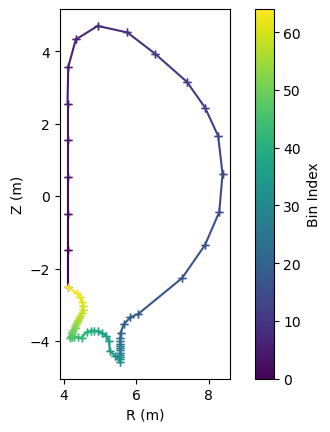

In [ ]:
from make_iter_bins import my_reactor

bins = my_reactor.first_wall.bins + my_reactor.divertor.bins

norm = plt.Normalize(0, len(bins))
cmap = plt.get_cmap("viridis")

for bin in bins:
    plt.plot(
        [bin.start_point[0], bin.end_point[0]],
        [bin.start_point[1], bin.end_point[1]],
        c=cmap(norm(bin.index)),
        marker="+",
    )
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Bin Index", ax=plt.gca())
plt.xlabel("R (m)")
plt.ylabel("Z (m)")
plt.gca().set_aspect("equal", adjustable="box")

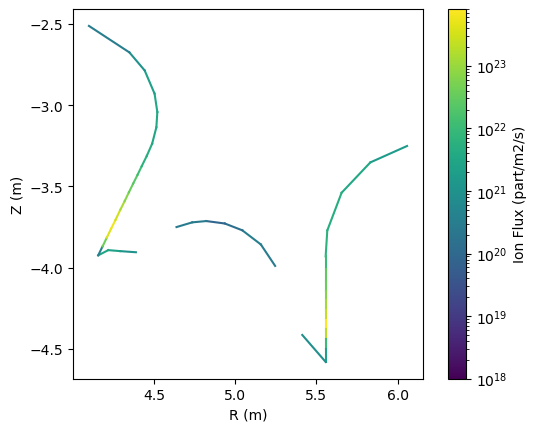

In [ ]:
from make_iter_bins import my_reactor

bins = my_reactor.first_wall.bins + my_reactor.divertor.bins
ion_fluxes = []
start_points = []
end_points = []

for bin in my_reactor.divertor.bins:
    ion_fluxes.append(
        float(plasma_data_handling.get_particle_flux("FP", bin=bin, t_rel=0, ion=True))
    )
    start_points.append(bin.start_point)
    end_points.append(bin.end_point)

from matplotlib.colors import LogNorm, Normalize
norm = LogNorm(1e18, max(ion_fluxes))
cmap = plt.get_cmap("viridis")


for start_point, end_point, ion_flux in zip(start_points, end_points, ion_fluxes):
    plt.plot(
        [start_point[0], end_point[0]],
        [start_point[1], end_point[1]],
        c=cmap(norm(ion_flux)),
    )
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Ion Flux (part/m2/s)", ax=plt.gca())
plt.xlabel("R (m)")
plt.ylabel("Z (m)")
plt.gca().set_aspect("equal", adjustable="box")

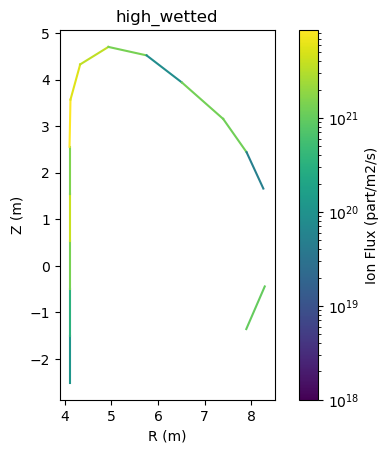

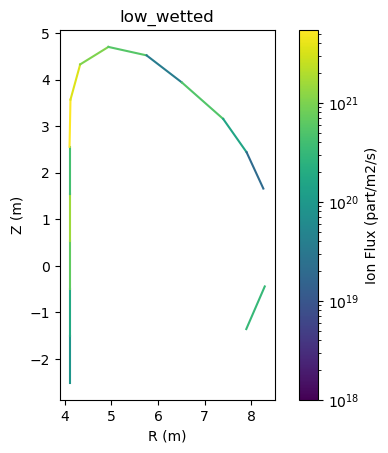

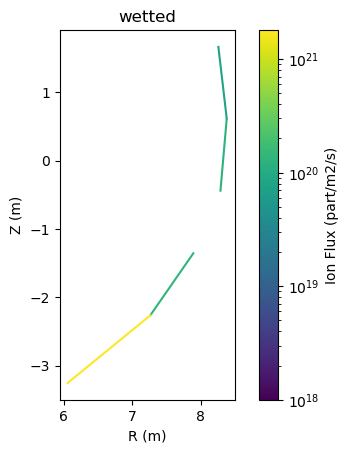

In [ ]:
from make_iter_bins import my_reactor
from matplotlib.colors import LogNorm

for mode in ["high_wetted", "low_wetted", "wetted"]:
    ion_fluxes = []
    start_points = []
    end_points = []
    for bin in my_reactor.first_wall.bins:
        for sub_bin in bin.sub_bins:
            if sub_bin.mode == mode:
                ion_flux = plasma_data_handling.get_particle_flux("FP", bin=sub_bin, t_rel=0, ion=True)
                ion_fluxes.append(ion_flux)

                start_points.append(bin.start_point)
                end_points.append(bin.end_point)


    norm = LogNorm(1e18, max(ion_fluxes))
    cmap = plt.get_cmap("viridis")


    for start_point, end_point, ion_flux in zip(start_points, end_points, ion_fluxes):
        plt.plot(
            [start_point[0], end_point[0]],
            [start_point[1], end_point[1]],
            c=cmap(norm(ion_flux)),
        )
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Ion Flux (part/m2/s)", ax=plt.gca())
    plt.xlabel("R (m)")
    plt.ylabel("Z (m)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(mode)
    plt.show()

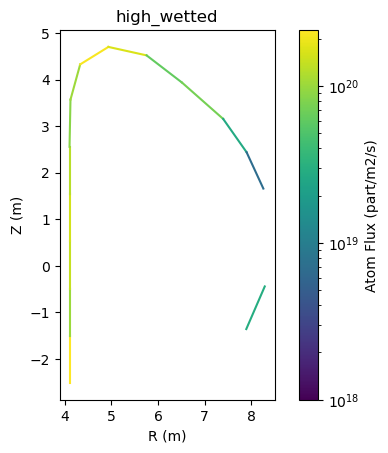

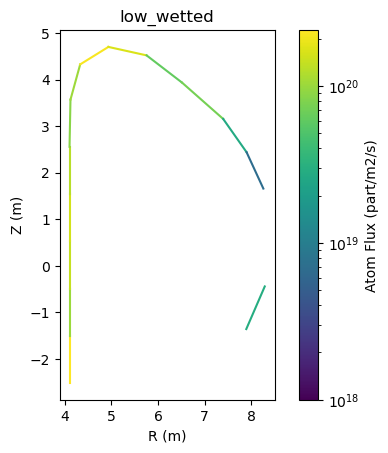

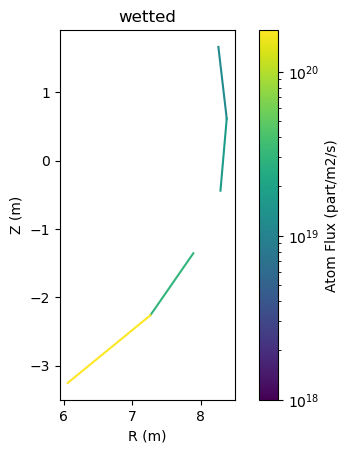

In [ ]:
from make_iter_bins import my_reactor
from matplotlib.colors import LogNorm

for mode in ["high_wetted", "low_wetted", "wetted"]:
    atom_fluxes = []
    start_points = []
    end_points = []
    for bin in my_reactor.first_wall.bins:
        for sub_bin in bin.sub_bins:
            if sub_bin.mode == mode:
                atom_flux = plasma_data_handling.get_particle_flux("FP", bin=sub_bin, t_rel=0, ion=False)
                atom_fluxes.append(atom_flux)

                start_points.append(bin.start_point)
                end_points.append(bin.end_point)


    norm = LogNorm(1e18, max(atom_fluxes))
    cmap = plt.get_cmap("viridis")


    for start_point, end_point, ion_flux in zip(start_points, end_points, atom_fluxes):
        plt.plot(
            [start_point[0], end_point[0]],
            [start_point[1], end_point[1]],
            c=cmap(norm(ion_flux)),
        )
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Atom Flux (part/m2/s)", ax=plt.gca())
    plt.xlabel("R (m)")
    plt.ylabel("Z (m)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(mode)
    plt.show()

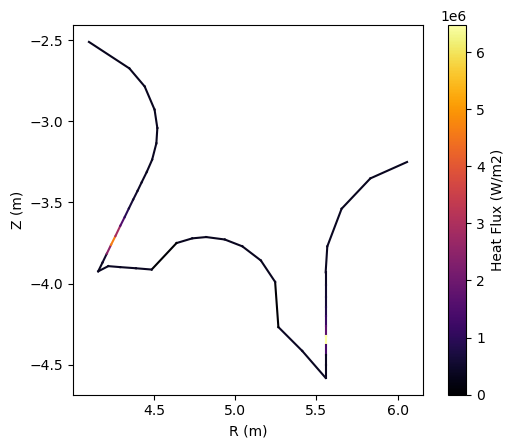

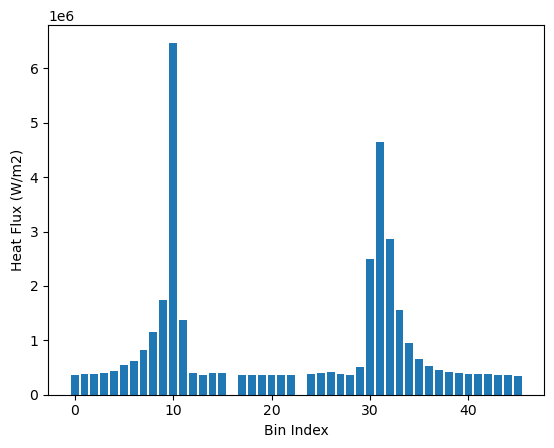

In [ ]:
from make_iter_bins import my_reactor

heat_fluxes = []
start_points = []
end_points = []
for bin in my_reactor.divertor.bins:
    heat_flux = plasma_data_handling.get_heat("FP", bin=bin, t_rel=0)
    heat_fluxes.append(heat_flux)

    start_points.append(bin.start_point)
    end_points.append(bin.end_point)


norm = Normalize(0, max(heat_fluxes))
cmap = plt.get_cmap("inferno")


for start_point, end_point, heat_flux in zip(start_points, end_points, heat_fluxes):
    plt.plot(
        [start_point[0], end_point[0]],
        [start_point[1], end_point[1]],
        c=cmap(norm(heat_flux)),
    )
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Heat Flux (W/m2)", ax=plt.gca())
plt.xlabel("R (m)")
plt.ylabel("Z (m)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

plt.bar(range(len(heat_fluxes)), heat_fluxes)
plt.xlabel("Bin Index")
plt.ylabel("Heat Flux (W/m2)")
plt.show()

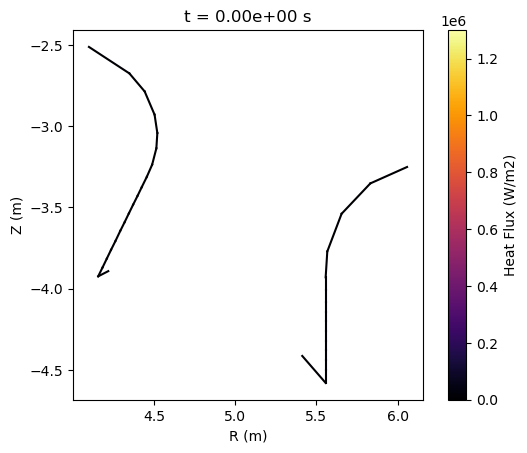

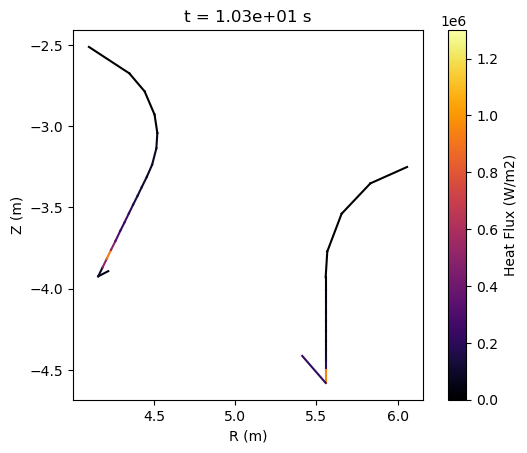

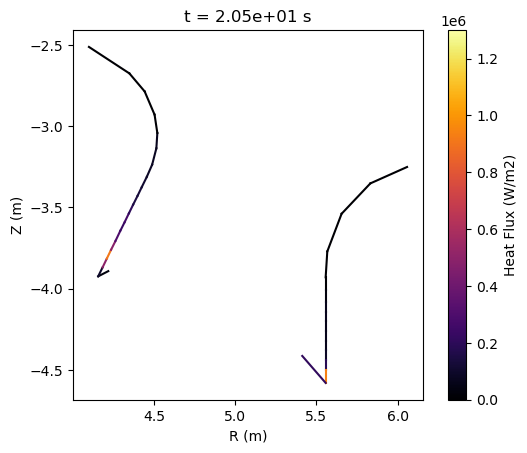

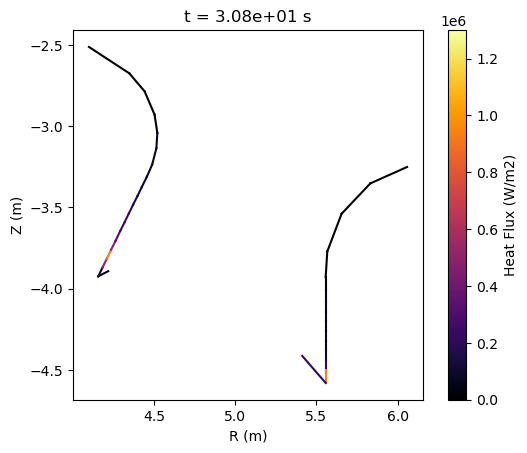

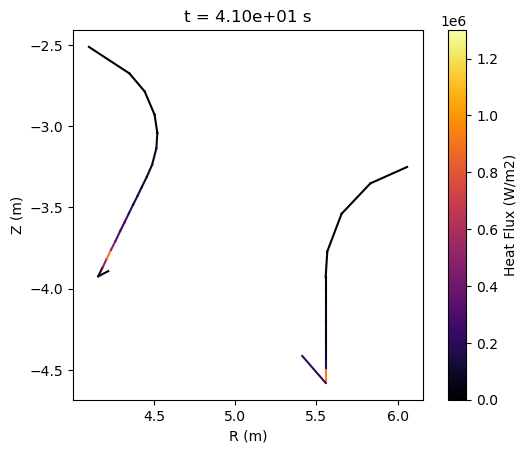

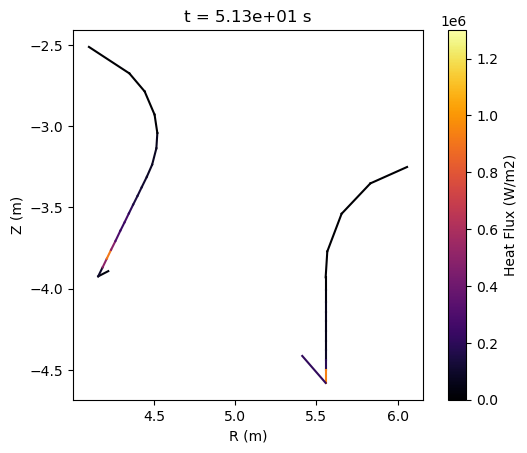

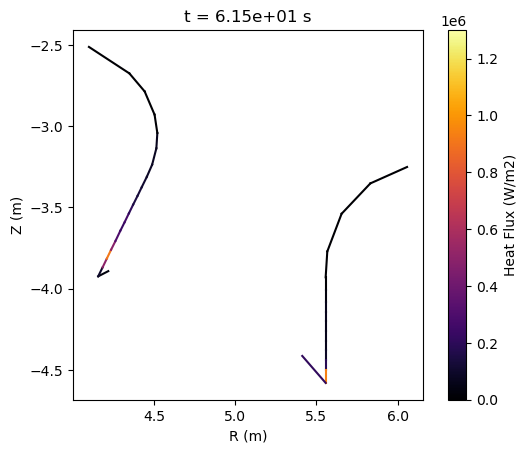

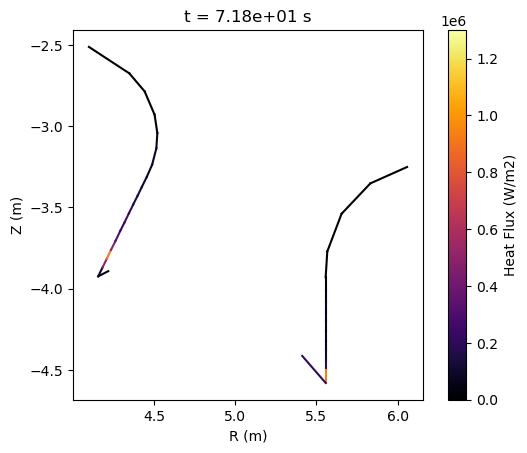

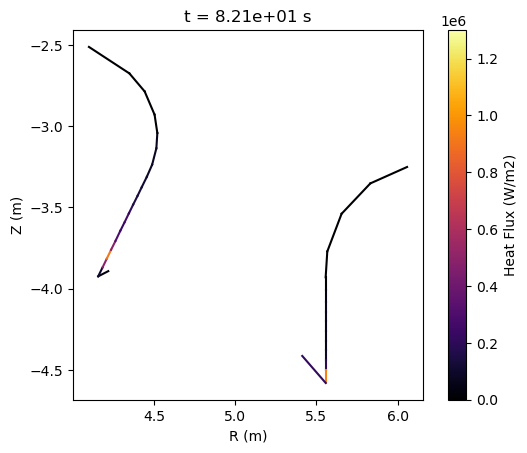

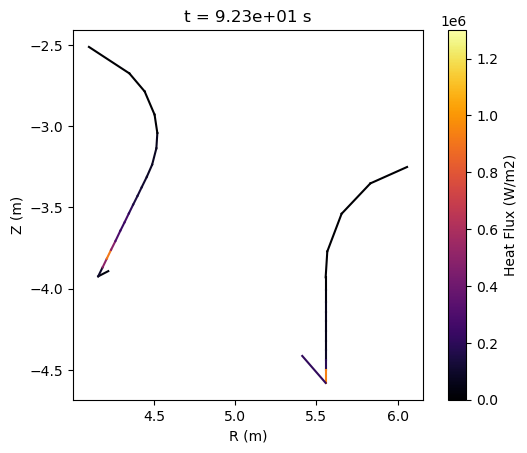

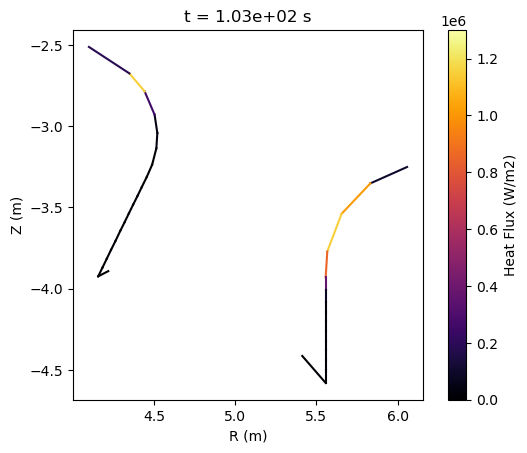

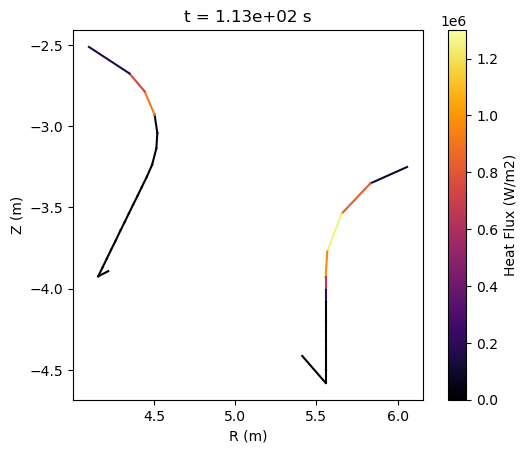

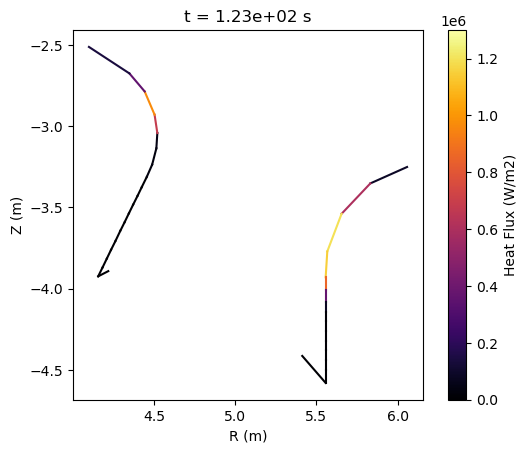

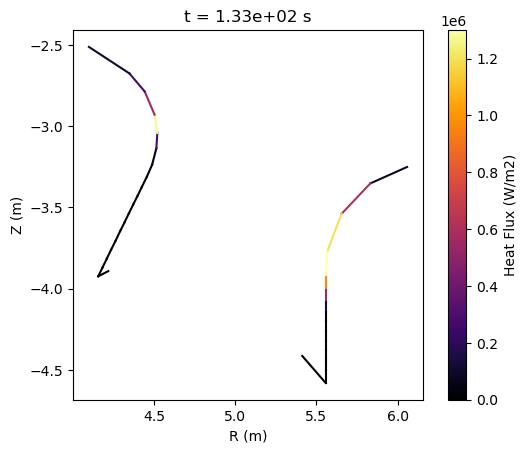

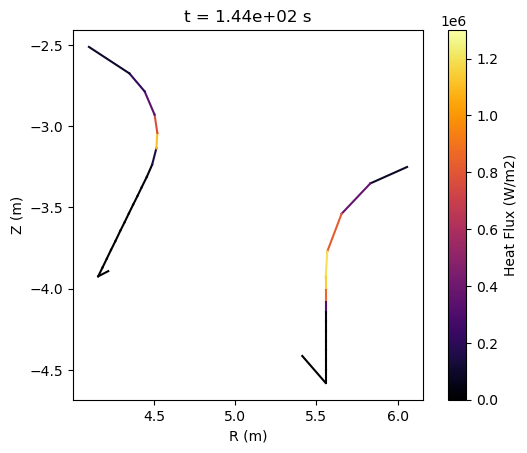

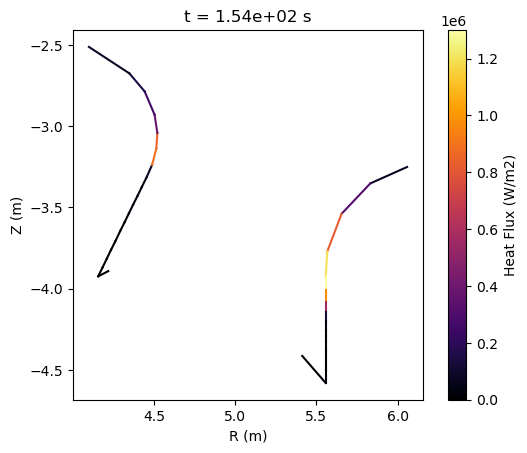

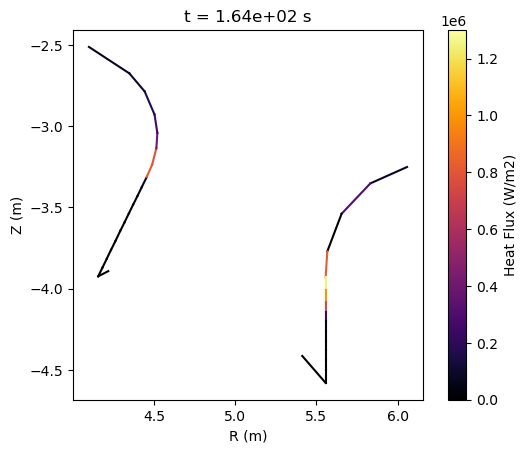

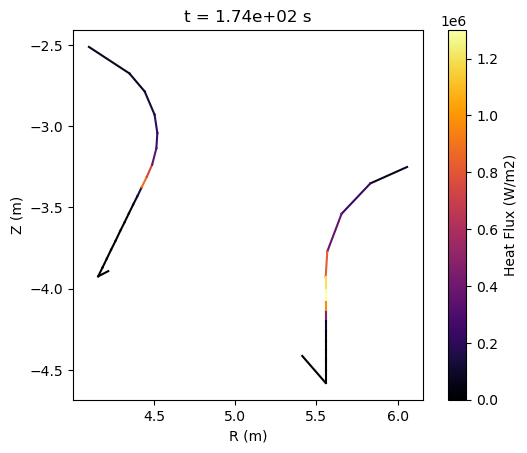

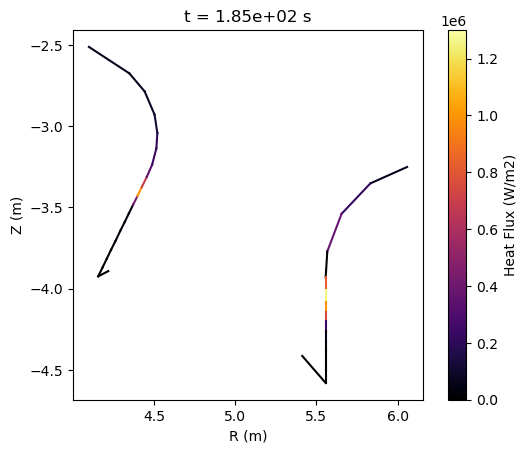

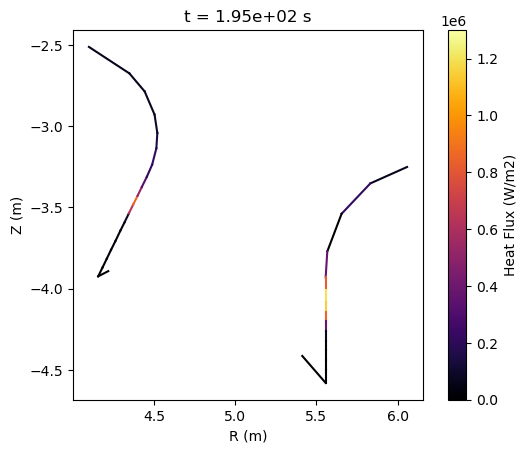

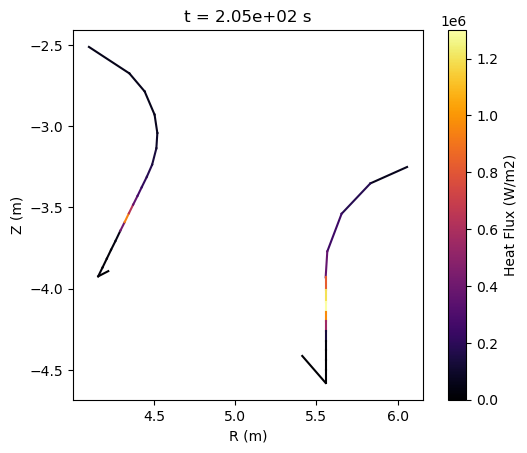

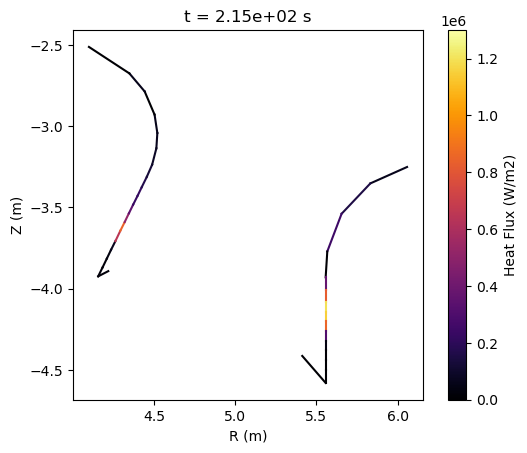

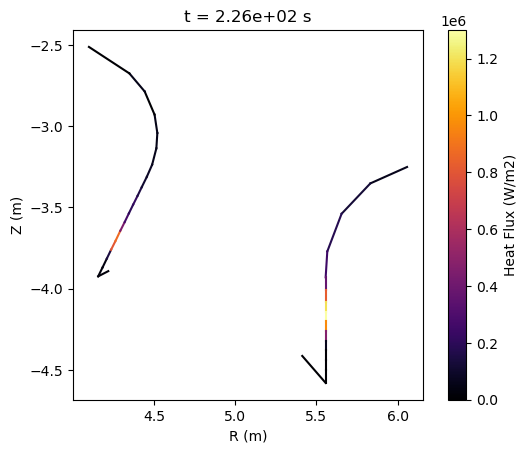

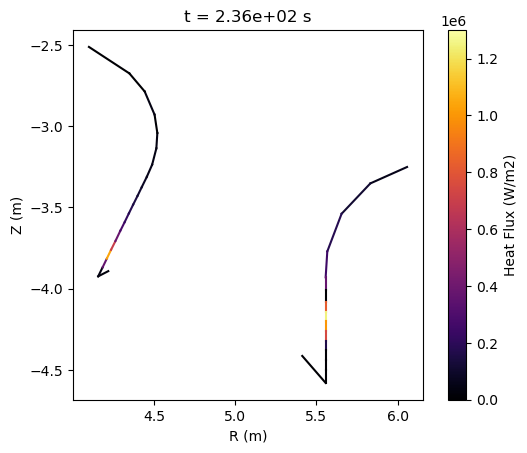

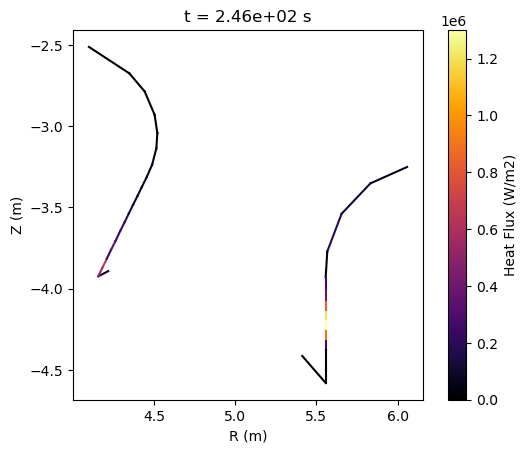

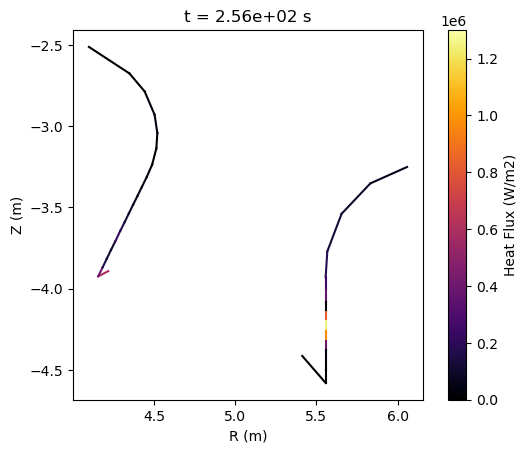

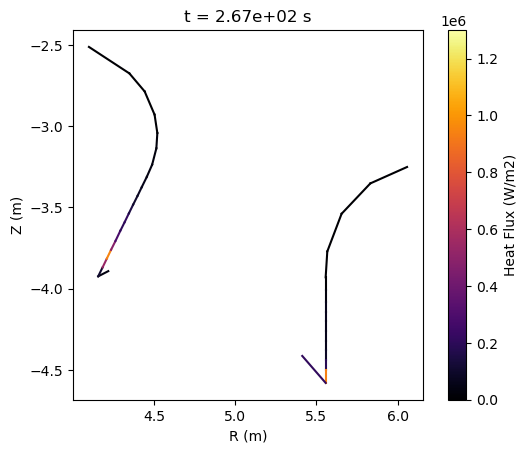

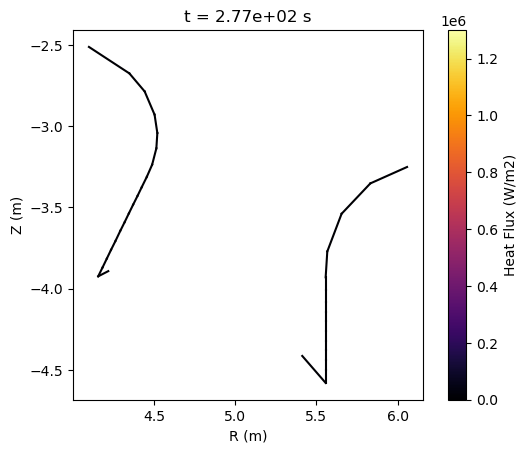

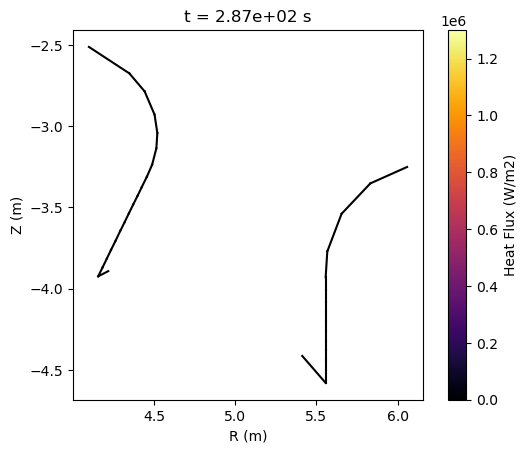

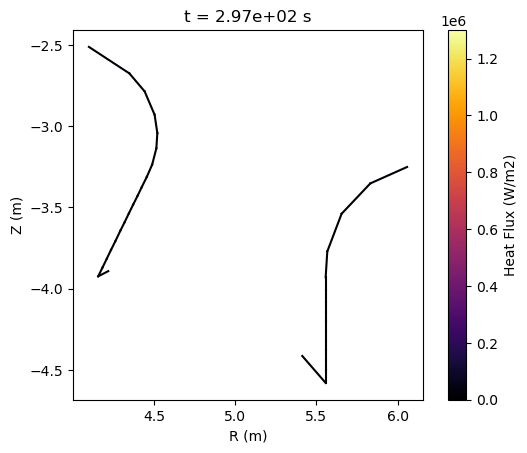

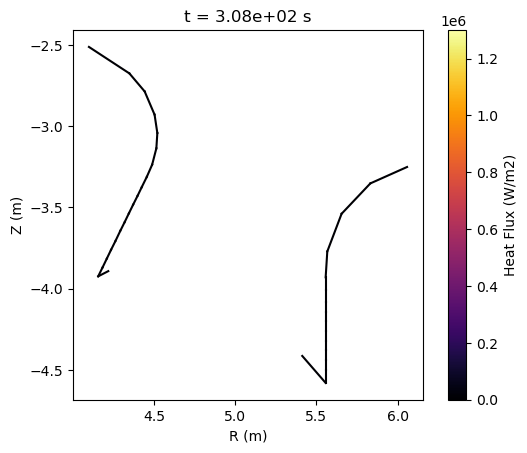

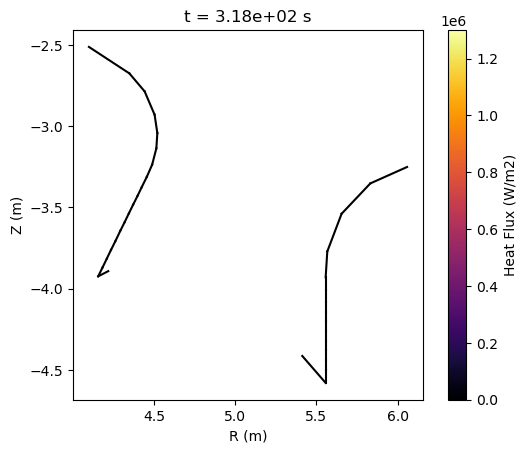

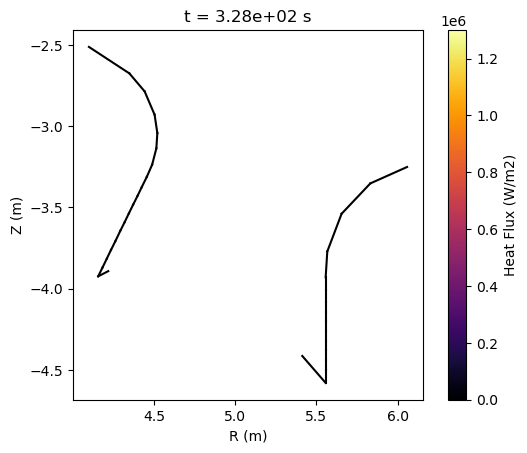

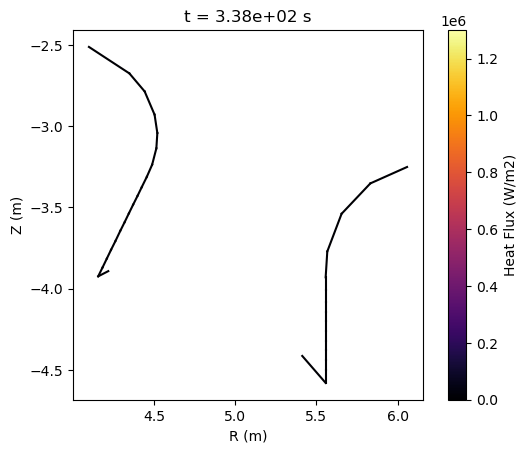

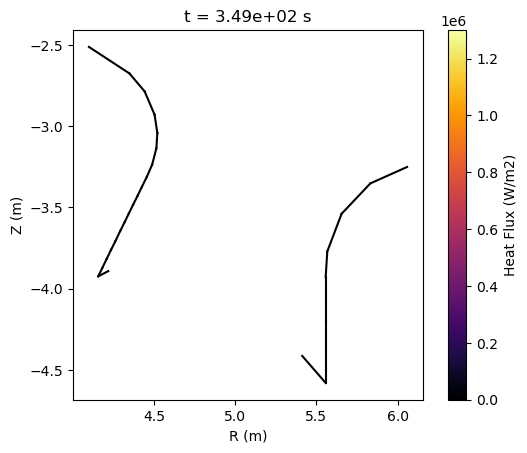

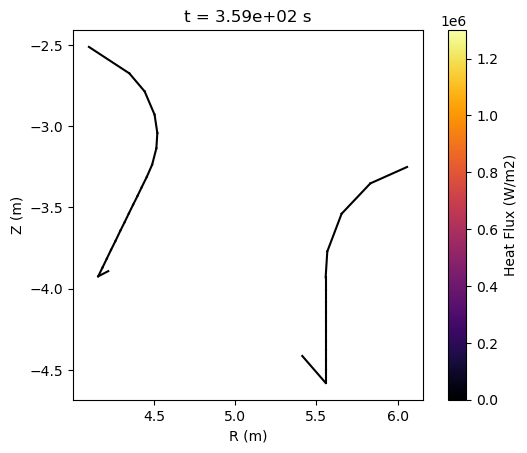

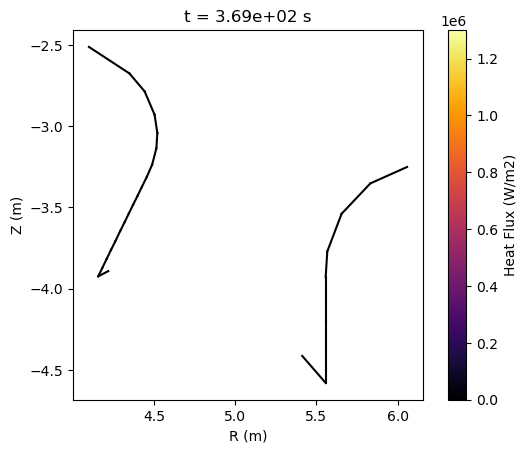

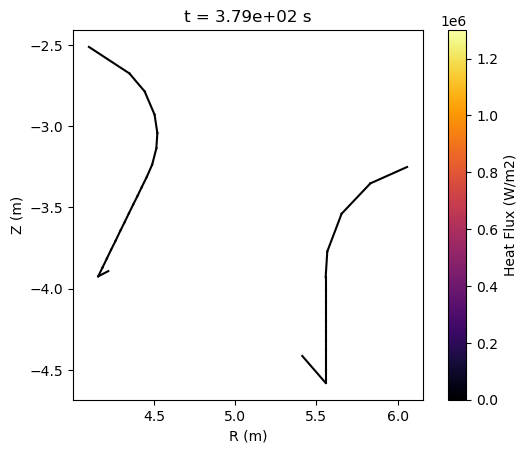

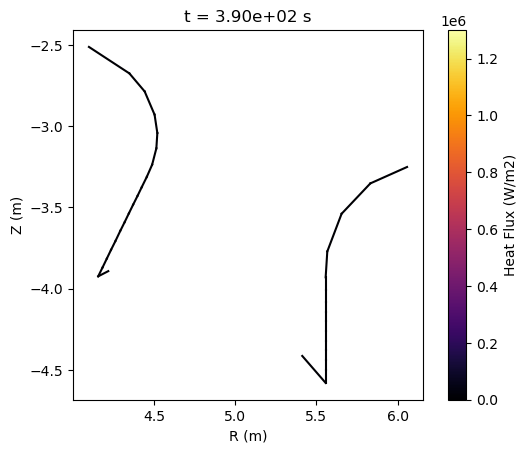

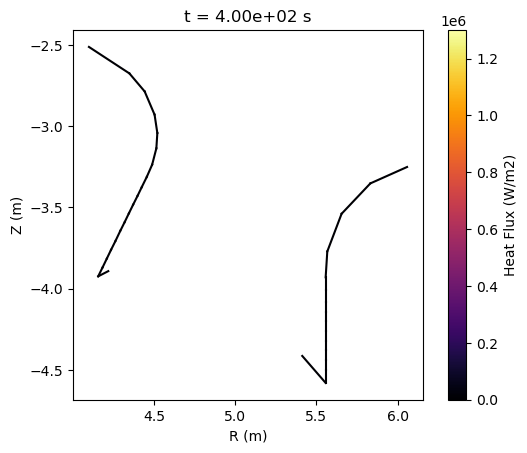

In [ ]:
cmap = plt.get_cmap("inferno")

def plot_frame(t: float):
    heat_fluxes = []
    start_points = []
    end_points = []
    for bin in my_reactor.divertor.bins:
        if not (bin.inner_bin or bin.outer_bin):
            continue
        heat_flux = plasma_data_handling.get_heat("RISP", bin=bin, t_rel=t)
        heat_fluxes.append(heat_flux)

        start_points.append(bin.start_point)
        end_points.append(bin.end_point)

    plt.figure()
    max_heat_flux = 1.3e6  # W/m2
    norm = Normalize(0, max_heat_flux)

    for start_point, end_point, heat_flux in zip(start_points, end_points, heat_fluxes):
        plt.plot(
            [start_point[0], end_point[0]],
            [start_point[1], end_point[1]],
            c=cmap(norm(heat_flux)),
        )

    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Heat Flux (W/m2)", ax=plt.gca())
    plt.xlabel("R (m)")
    plt.ylabel("Z (m)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"t = {t:.2e} s")
    plt.savefig(f"figs/divertor_heat_flux_{t:.2e}.png")

for t in np.linspace(0, 400, 40):
    plot_frame(t)

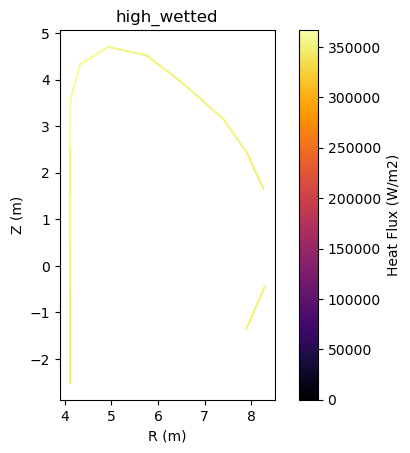

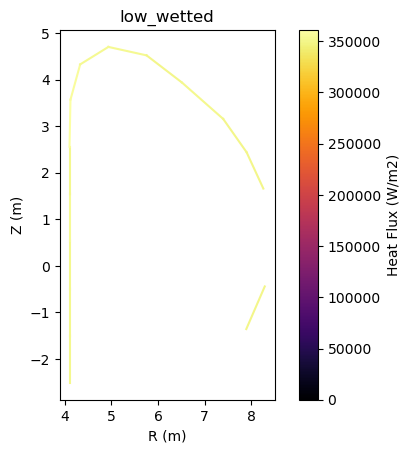

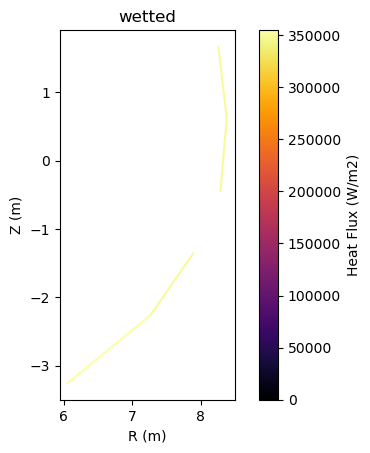

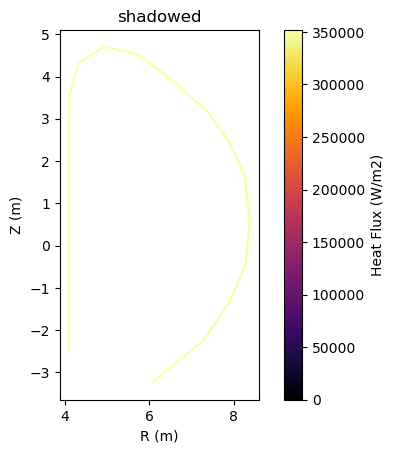

In [ ]:
for mode in ["high_wetted", "low_wetted", "wetted", "shadowed"]:
    heat_fluxes = []
    start_points = []
    end_points = []
    for bin in my_reactor.first_wall.bins:
        for sub_bin in bin.sub_bins:
            if sub_bin.mode == mode:
                heat_flux = plasma_data_handling.get_heat("FP", bin=sub_bin, t_rel=0)
                heat_fluxes.append(heat_flux)

                start_points.append(bin.start_point)
                end_points.append(bin.end_point)


    norm = Normalize(0, max(heat_fluxes))
    cmap = plt.get_cmap("inferno")


    for start_point, end_point, heat_flux in zip(start_points, end_points, heat_fluxes):
        plt.plot(
            [start_point[0], end_point[0]],
            [start_point[1], end_point[1]],
            c=cmap(norm(heat_flux)),
        )
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Heat Flux (W/m2)", ax=plt.gca())
    plt.xlabel("R (m)")
    plt.ylabel("Z (m)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(mode)
    plt.show()